# Dataset Description

The dataset incorporates 12 features and 28 typologies (split between 11 normal and 17 suspicious). These were selected based on existing datasets, the academic literature, and interviews with AML specialists. The dataset comprises 9,504,852 transactions, of which 0.1039% are suspicious. It also includes 15 graphical network structures to represent the transaction flow within these typologies. The structures, while sometimes shared among typologies, vary significantly in parameters to increase complexities and challenge detection efforts. More details about these typologies are available in the paper above. The dataset is an updated version compared to the paper.

Features of the SAML-D dataset:

• Time and Date: Essential for tracking transaction chronology.

• Sender and Receiver Account Details: Helps uncover behavioural patterns and complex banking connections.

• Amount: Indicates transaction values to identify suspicious activities.

• Payment Type: Includes various methods like credit card, debit card, cash, ACH transfers, cross-border, and cheque.

• Sender and Receiver Bank Location: Pinpoints high-risk regions including Mexico, Turkey, Morocco, and the UAE.

• Payment and Receiver Currency: Align with location features, adding complexity when mismatched.

• 'Is Suspicious' Feature: Binary indicator differentiating normal from suspicious transactions.

• Type: Classifies typologies, offering deeper insights.


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy.stats import skew
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [3]:
raw_df = pd.read_csv("~/Downloads/SAML-D.csv")
raw_df.shape

(9504852, 12)

In [4]:
df = raw_df.sample(n=100000, random_state=1) # ensuring only 100k are sampled, and ensuring reproducibility
df.shape

(100000, 12)

In [5]:
# Start EDA
df.head()


,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
9232719,02:08:46,2023-08-14,4248061080,9527052910,13480.74,Mexican Peso,UK pounds,UK,UK,Debit card,0,Normal_Plus_Mutual
7996180,19:48:23,2023-07-02,9130896737,908371799,10480.05,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Fan_Out
8575435,12:04:24,2023-07-22,1466348255,8545558838,26232.35,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Fan_Out
614744,17:08:02,2022-10-28,2181923623,6234034932,447.07,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Small_Fan_Out
4092093,22:44:17,2023-02-21,8596132461,3638213339,1005.62,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out


In [12]:
df.columns

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type'],
      dtype='object')

In [13]:
df.info

<bound method DataFrame.info of              Time        Date  Sender_account  Receiver_account    Amount  \
9232719  02:08:46  2023-08-14      4248061080        9527052910  13480.74   
7996180  19:48:23  2023-07-02      9130896737         908371799  10480.05   
8575435  12:04:24  2023-07-22      1466348255        8545558838  26232.35   
614744   17:08:02  2022-10-28      2181923623        6234034932    447.07   
4092093  22:44:17  2023-02-21      8596132461        3638213339   1005.62   
...           ...         ...             ...               ...       ...   
963141   13:45:26  2022-11-09      5775986392        2342938066   5635.32   
8020998  16:48:08  2023-07-03      8746213790        1684541326   2775.11   
8311096  14:06:44  2023-07-13      6145055160        8251429562   4870.95   
8582742  17:02:22  2023-07-22      6439676872         266713133   3256.08   
4931563  20:01:42  2023-03-21       976249309        3871786883  22085.27   

        Payment_currency Received_currency 

<Axes: xlabel='Is_laundering', ylabel='count'>

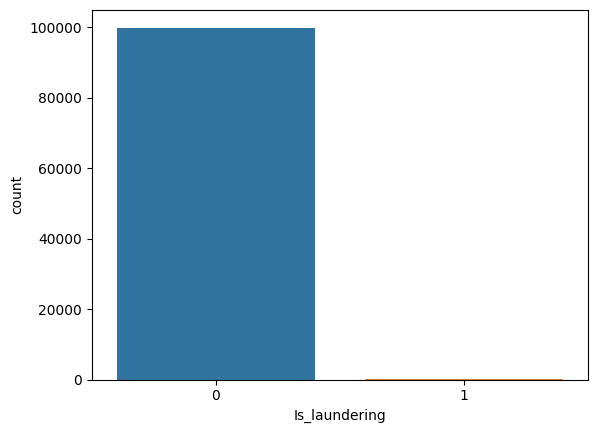

In [6]:
# Checking imbalances in classes
sns.countplot(data=df, x='Is_laundering')

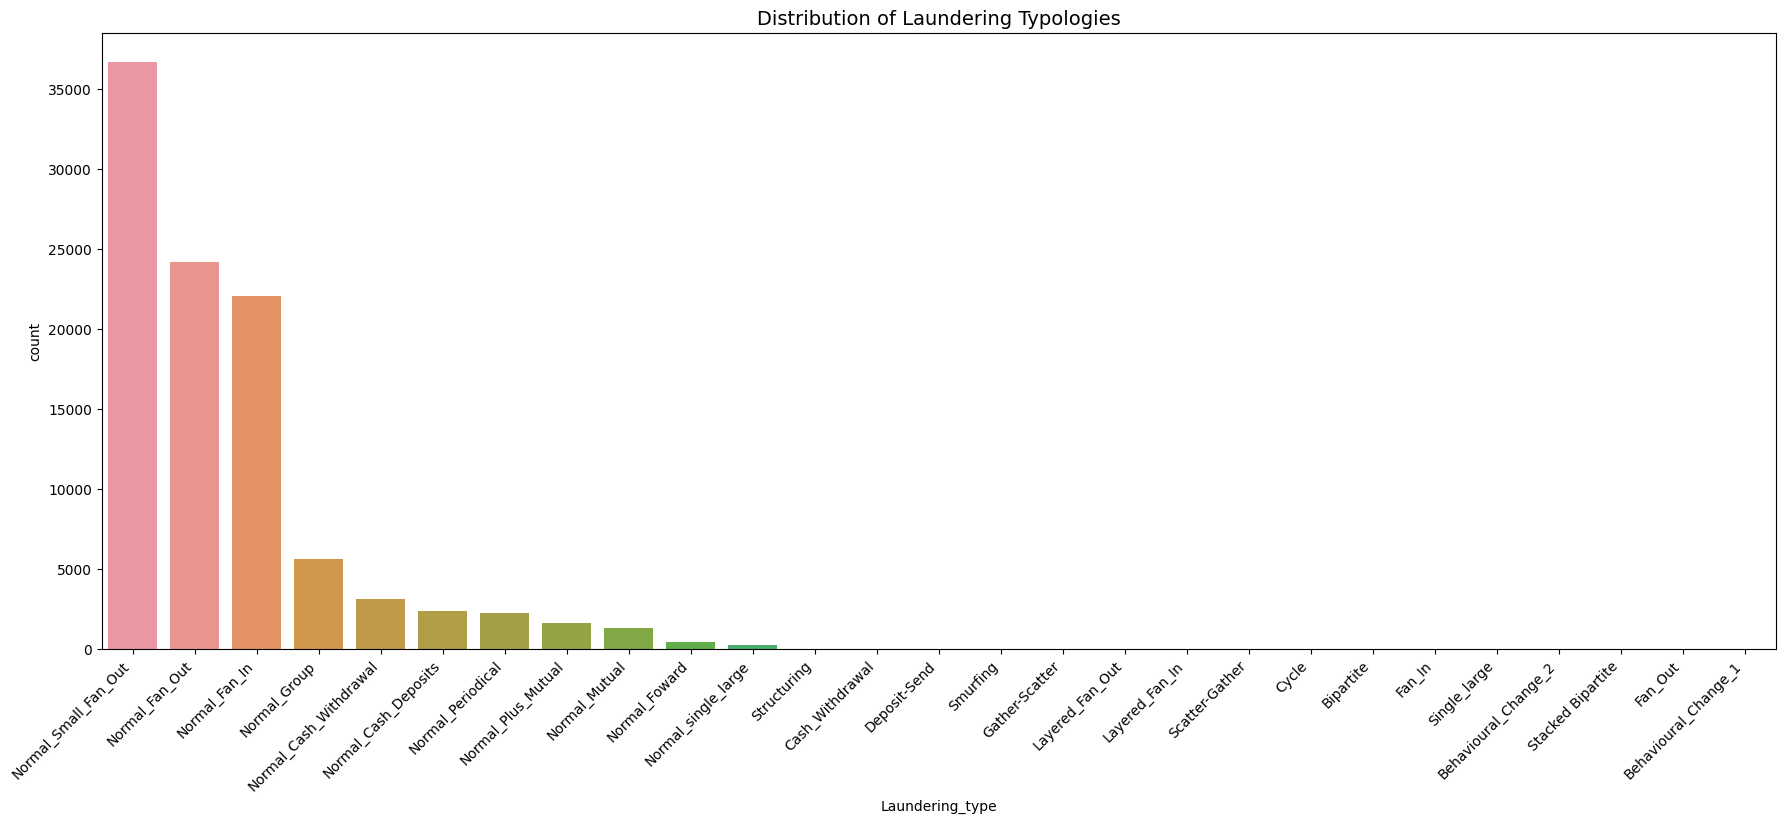

In [9]:
laundering_counts = df['Laundering_type'].value_counts()
filtered_types = laundering_counts[laundering_counts > 0].index
plt.figure(figsize=(min(25, len(filtered_types) * 0.8), 8))
sns.countplot(data=df, x='Laundering_type', order=filtered_types)
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Laundering Typologies", fontsize=14)
plt.show()

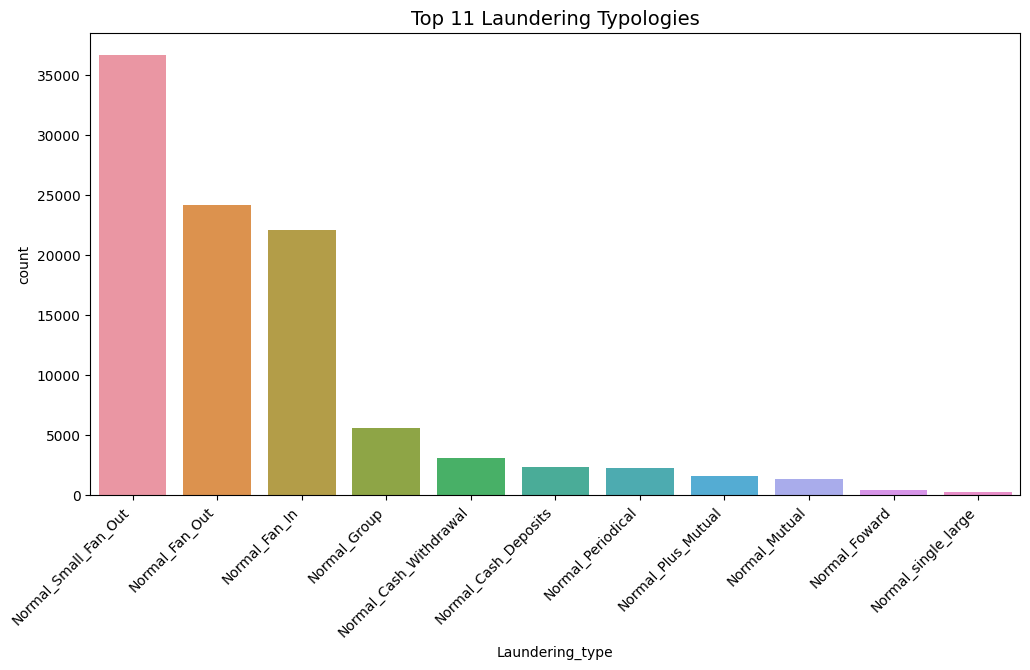

In [10]:
# Showing only the top 11 most frequent categories for easier visualization]
top_11_types = df['Laundering_type'].value_counts().nlargest(11).index
df_top_11 = df[df['Laundering_type'].isin(top_11_types)]
plt.figure(figsize=(12, 6))
sns.countplot(data=df_top_11, x='Laundering_type', order=top_11_types)
plt.xticks(rotation=45, ha='right')
plt.title("Top 11 Laundering Typologies", fontsize=14)
plt.show()

In [14]:
## Converting date into datetime format

df['Date'] = pd.to_datetime(df['Date'])

# Extract month, day, and week

df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Day'] = pd.to_datetime(df['Date']).dt.day
df['Week'] = df['Date'].dt.isocalendar().week

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 9232719 to 4931563
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Time                    100000 non-null  object        
 1   Date                    100000 non-null  datetime64[ns]
 2   Sender_account          100000 non-null  int64         
 3   Receiver_account        100000 non-null  int64         
 4   Amount                  100000 non-null  float64       
 5   Payment_currency        100000 non-null  object        
 6   Received_currency       100000 non-null  object        
 7   Sender_bank_location    100000 non-null  object        
 8   Receiver_bank_location  100000 non-null  object        
 9   Payment_type            100000 non-null  object        
 10  Is_laundering           100000 non-null  int64         
 11  Laundering_type         100000 non-null  object        
 12  Year                    1000

<Axes: xlabel='Year', ylabel='count'>

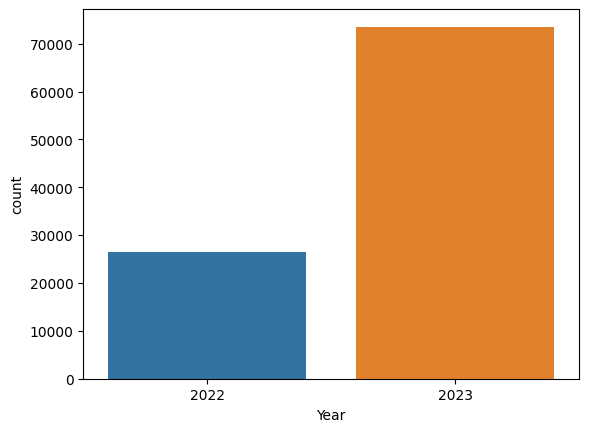

In [ ]:
# When was the data collected?
sns.countplot(data=df, x='Year')

In [17]:
# number of transactions per payment type
transactions_per_payment_type = df['Payment_type'].value_counts()

# number of laundering transactions per payment type
laundering_transactions_per_payment_type = df[df['Is_laundering'] == 1].groupby('Payment_type').size()

transactions_per_payment_type, laundering_transactions_per_payment_type

(Payment_type
 Cheque             21282
 Debit card         21214
 Credit card        21171
 ACH                20996
 Cross-border        9861
 Cash Withdrawal     3090
 Cash Deposit        2386
 Name: count, dtype: int64,
 Payment_type
 ACH                14
 Cash Deposit       16
 Cash Withdrawal    12
 Cheque              9
 Credit card        17
 Cross-border       23
 Debit card          9
 dtype: int64)

In [20]:
# How does the laundering and normal dataset look like? 
laundering_stats = df[df['Is_laundering'] == 1]['Amount'].agg(['max', 'mean', 'min'])

normal_stats = df[df['Is_laundering'] == 0]['Amount'].agg(['max', 'mean', 'min'])

print("Laundering Transactions Stats:\n", laundering_stats)
print("\nNormal Transactions Stats:\n", normal_stats)

Laundering Transactions Stats:
 max     380012.980000
mean     17353.891942
min         50.100000
Name: Amount, dtype: float64

Normal Transactions Stats:
 max     948662.900000
mean      8679.280692
min          9.150000
Name: Amount, dtype: float64


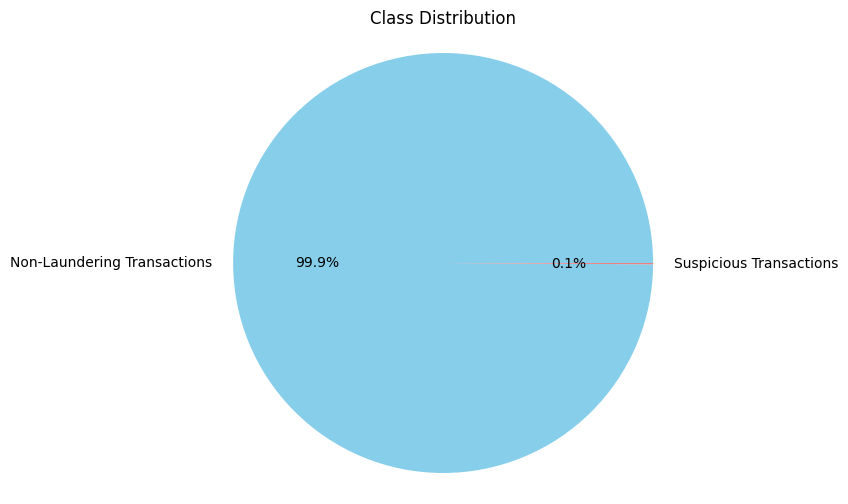

In [21]:
# What proportion of dataset is suspicious? 
class_distribution = df['Is_laundering'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])

plt.title('Class Distribution')
plt.axis('equal')

plt.show();

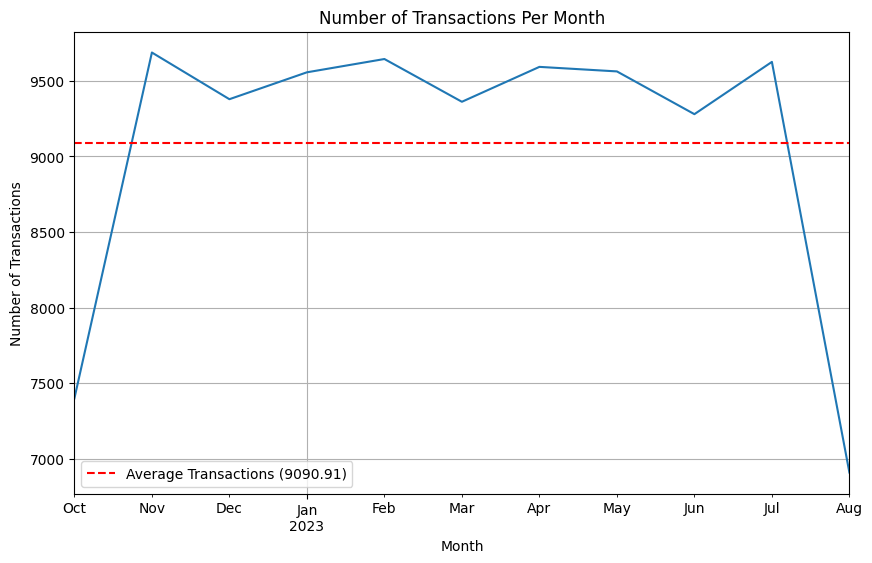

In [22]:
# What does the distribution of transactions look like per month, across the year? 
## Monthly Transactions

monthly_transactions = df.groupby(df['Date'].dt.to_period('M')).size()

average_monthly_transactions = monthly_transactions.mean()

plt.figure(figsize=(10, 6))
monthly_transactions.plot(kind='line')
plt.axhline(y=average_monthly_transactions, color='r', linestyle='--', label=f'Average Transactions ({average_monthly_transactions:.2f})')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Per Month')
plt.legend()
plt.grid(True)
plt.show();

In [23]:
# Of the 100k transactions, how many are suspicious?
df['Is_laundering'].value_counts()

Is_laundering
0    99900
1      100
Name: count, dtype: int64

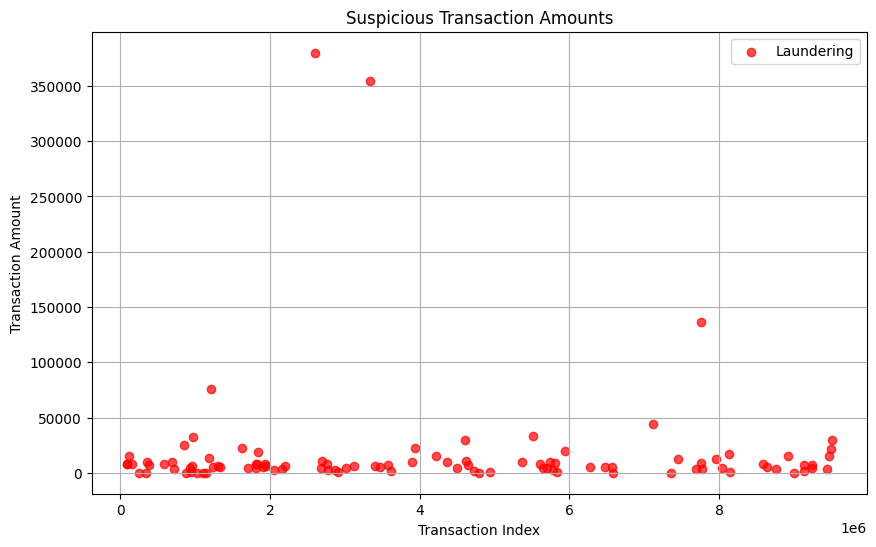

In [24]:
# What amount of money are they laundering? 

laundering_data = df[df['Is_laundering'] == 1]
non_laundering_data = df[df['Is_laundering'] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(laundering_data.index, laundering_data['Amount'], color='red', label='Laundering', alpha=0.7)

plt.title('Suspicious Transaction Amounts')
plt.xlabel('Transaction Index')
plt.ylabel('Transaction Amount')
plt.legend()
plt.grid(True)
plt.show();

Original Skewness: 24.42962605031987
Log-Transformed Skewness: -1.0077407190672134


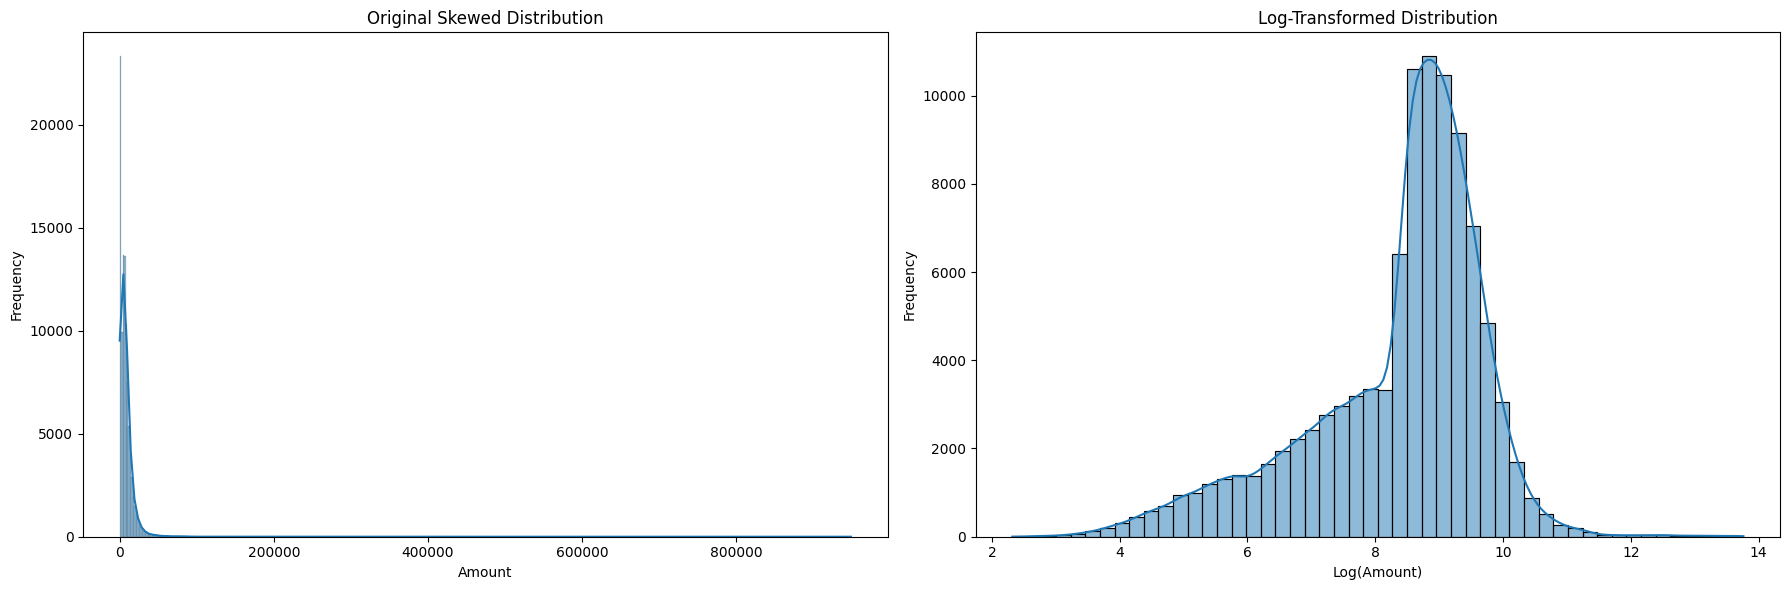

In [25]:
# How asymmetric is the data distribution compared to a normal distribution?

skewed_data = df['Amount']

original_skewness = skew(skewed_data)
print(f"Original Skewness: {original_skewness}")

# Apply a log transformation
log_transformed_data = np.log1p(skewed_data)
# skewness after log transformation
transformed_skewness = skew(log_transformed_data)
print(f"Log-Transformed Skewness: {transformed_skewness}")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(skewed_data, bins=500, kde=True, ax=ax[0])
ax[0].set_title('Original Skewed Distribution')
ax[0].set_xlabel('Amount')
ax[0].set_ylabel('Frequency')

sns.histplot(log_transformed_data, bins=50, kde=True, ax=ax[1])
ax[1].set_title('Log-Transformed Distribution')
ax[1].set_xlabel('Log(Amount)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show();

In [26]:
# How does the distribution of money laundering look like?

total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)
laundering_count_pivot = df[df['Is_laundering'] == 1].groupby('Payment_type').size().to_frame('Laundering_Count')
normal_count_pivot = df[df['Is_laundering'] == 0].groupby('Payment_type').size().to_frame('Normal_Count')

combined_pivot = total_amount_pivot.join([laundering_count_pivot, normal_count_pivot], how='outer')
combined_pivot = combined_pivot.fillna(0)

cm = sns.light_palette("blue", as_cmap=True)
styled_combined_pivot = combined_pivot.style.background_gradient(cmap=cm)

styled_combined_pivot

,Amount,Laundering_Count,Normal_Count
Payment_type,,,
ACH,191280642.174001,14,20982
Cash Deposit,5292875.760000,16,2370
Cash Withdrawal,476488.160000,12,3078
Cheque,191394048.379559,9,21273
Credit card,188435992.010639,17,21154
Cross-border,98300819.645930,23,9838
Debit card,193614664.204063,9,21205


In [27]:
# The time is most likely too granular for our analysis, as our temporal analysis should be yearly instead of by the hour/minute/second. 
# Hence, we should drop the time column

columns_to_drop = ['Time', 'Date']

df.drop(columns=columns_to_drop, inplace=True)

df.columns

Index(['Sender_account', 'Receiver_account', 'Amount', 'Payment_currency',
       'Received_currency', 'Sender_bank_location', 'Receiver_bank_location',
       'Payment_type', 'Is_laundering', 'Laundering_type', 'Year', 'Month',
       'Day', 'Week'],
      dtype='object')

In [29]:
# How many columns and types of columns do we have now? 
num_cols = df.select_dtypes(exclude="object").columns
print(f"We have {len(num_cols)} numerical columns: {num_cols.tolist()}")

categorical_cols = df.select_dtypes(include="object").columns 
print(f"We have {len(categorical_cols)} categorical columns: {categorical_cols.tolist()}")

We have 8 numerical columns: ['Sender_account', 'Receiver_account', 'Amount', 'Is_laundering', 'Year', 'Month', 'Day', 'Week']
We have 6 categorical columns: ['Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Laundering_type']


In [30]:
# Is there any missing values? 
df.isnull().sum()

Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
Laundering_type           0
Year                      0
Month                     0
Day                       0
Week                      0
dtype: int64

In [31]:
# How many unique categories are there in the categorical columns? 

unique_counts = df[categorical_cols].nunique()
print("Unique columns in the DataFrame: \n", unique_counts)

Unique columns in the DataFrame: 
 Payment_currency          13
Received_currency         13
Sender_bank_location      18
Receiver_bank_location    18
Payment_type               7
Laundering_type           27
dtype: int64


# Model Training

In [32]:
X = df.drop(columns=["Is_laundering"], axis=1)
y = df["Is_laundering"]

In [33]:
numerical_features = X.select_dtypes(exclude="object").columns

numerical_features

Index(['Sender_account', 'Receiver_account', 'Amount', 'Year', 'Month', 'Day',
       'Week'],
      dtype='object')

In [34]:
categorical_features = X.select_dtypes(include="object").columns

categorical_features

Index(['Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Laundering_type'],
      dtype='object')

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder

## Define the pipeline

num_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ordinalencoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))  # Encodes unseen categories
    ]
)

In [39]:
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer(transformers=[
    ("OrdinalEncoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
    ("RobustScaler", RobustScaler(), numerical_features)
], remainder="passthrough")

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Transform the datasets

X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [42]:
print(f"Shape of training data: ", X_train.shape, y_train.shape)
print(f"Shape of testing data: ", X_test.shape, y_test.shape)

Shape of training data:  (80000, 13) (80000,)
Shape of testing data:  (20000, 13) (20000,)


In [43]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4,8,16],
    'eta': [0.1,0.2,0.3],
}

xgb = XGBClassifier(eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=2,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

best_model = grid_search.best_estimator_


y_pred = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred)
print("Test AUC: ", test_auc)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END ...............................eta=0.1, max_depth=4; total time=   0.3s
[CV] END ...............................eta=0.1, max_depth=4; total time=   0.2s
[CV] END ...............................eta=0.1, max_depth=8; total time=   0.2s
[CV] END ...............................eta=0.1, max_depth=8; total time=   0.2s
[CV] END ..............................eta=0.1, max_depth=16; total time=   0.2s
[CV] END ..............................eta=0.1, max_depth=16; total time=   0.2s
[CV] END ...............................eta=0.2, max_depth=4; total time=   0.2s
[CV] END ...............................eta=0.2, max_depth=4; total time=   0.2s
[CV] END ...............................eta=0.2, max_depth=8; total time=   0.2s
[CV] END ...............................eta=0.2, max_depth=8; total time=   0.2s
[CV] END ..............................eta=0.2, max_depth=16; total time=   0.2s
[CV] END ..............................eta=0.2, m

Test Set AUC:  1.0


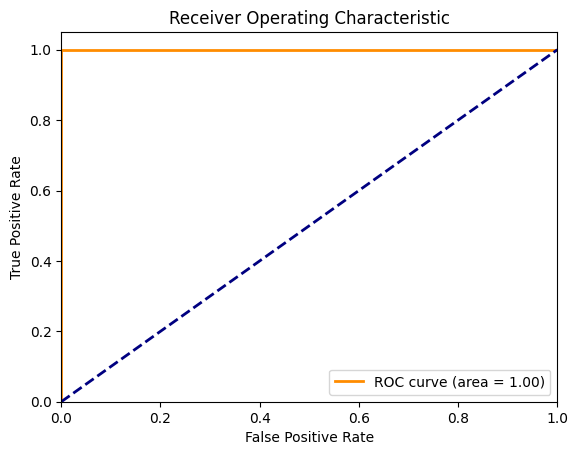

In [44]:
# Evaluating the model
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

test_probabilities = best_model.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, test_probabilities)
print("Test Set AUC: ", test_auc)

fpr, tpr, thresholds = roc_curve(y_test, test_probabilities)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show();

Desired TPR of around 90%:


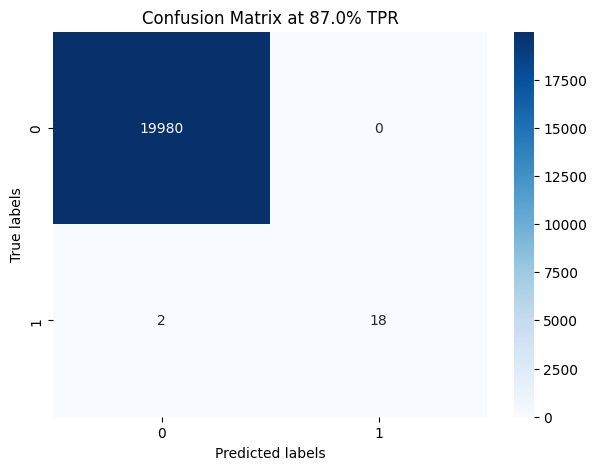

False Positive Rate (FPR): 0.000
True Positive Rate (TPR): 0.900


In [45]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
desired_tpr = 0.87
closest_threshold = thresholds[np.argmin(np.abs(tpr - desired_tpr))]
print(f"Desired TPR of around 90%:")

y_pred = (test_probabilities >= closest_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix at {desired_tpr*100}% TPR')
plt.show()

tn, fp, fn, tp = cm.ravel()
fpr_cm = fp / (fp + tn)
tpr_cm = tp / (tp + fn)

print(f"False Positive Rate (FPR): {fpr_cm:.3f}")
print(f"True Positive Rate (TPR): {tpr_cm:.3f}")

In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19980
           1       1.00      0.90      0.95        20

    accuracy                           1.00     20000
   macro avg       1.00      0.95      0.97     20000
weighted avg       1.00      1.00      1.00     20000



In [47]:
# This data looks like it is imbalanced, so we should balance the dataset using SMOTE 
# This allows us to sample more data, while keeping the dataset balanced 


from imblearn.over_sampling import SMOTE
from collections import Counter
counter = Counter(y_train)

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train_os)

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")


print("Balanced dataset data shape: ", X_train_os.shape, y_train_os.shape)

Class= 0, n=79920 (99.90%)
Class= 1, n=80 (0.10%)
Class= 0, n=79920 (99.90%)
Class= 1, n=79920 (99.90%)
Balanced dataset data shape:  (159840, 13) (159840,)
